## Intro to Data Science Visualization with datashader
Visualization is one of the key parts in a Data Science project. It allows us to get a global sense of our data and to understand better our results. 
There are many free and non-free tools in the market to make data visualization. One of my favourites is [datashader](https://github.com/bokeh/datashader), an open source python library that allows to visualize big amounts of data with a clean and nice API. 

In [60]:
#Load all libraries
import pandas as pd
import numpy as np
import xarray as xr
import datashader as ds
import datashader.transfer_functions as tf
from datashader import reductions
from bokeh.palettes import Greens3
from datashader.bokeh_ext import InteractiveImage
from bokeh.plotting import figure, output_notebook
from bokeh.tile_providers import WMTSTileSource, STAMEN_TONER, STAMEN_TERRAIN
from datashader.colors import colormap_select, Hot, inferno
from functools import partial
import os,sys  
import wget
import zipfile
import math

output_notebook()


print(sys.version)

Loading BokehJS ...

3.5.2 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


Let's start with something simple. Let's draw a set of points taken from a gaussian distribution of 2 different categories. Each category will be composed by 100.000 points. The first one has a wide standard deviation, so it will be scattered, and the second one will be more compressed. 

In [2]:
# Dataset generation
np.random.seed(1)
num=100000
dists = {cat: pd.DataFrame(dict(x=np.random.normal(x,std,num),
                                y=np.random.normal(y,std,num),
                                val=val,cat=cat))
         for x,y,std,val,cat in 
         [(3,3,5,10,"d1"), (2,-5,0.2,50,"d2")]}
df = pd.concat(dists,ignore_index=True)
df["cat"]=df["cat"].astype("category")
df.tail()

,cat,val,x,y
199995,d2,50,1.667631,-5.148703
199996,d2,50,1.904505,-5.090921
199997,d2,50,2.051864,-4.807369
199998,d2,50,2.085428,-5.103127
199999,d2,50,2.004584,-4.879147


With datashader we can control the canvas size and how to show the data. In this case we are aggregating data. You can also control the colors and the background. In this case we are going to represent the data like if you were in Matrix.

In [3]:
%%time 
canvas = ds.Canvas(plot_width=400, plot_height=400, x_range=(-10,10), y_range=(-10,10))
agg = canvas.points(df,'x','y',agg=reductions.count())
img = tf.shade(agg, cmap=Greens3, how='eq_hist')
background = "black"
img = tf.set_background(img, background)

Wall time: 291 ms


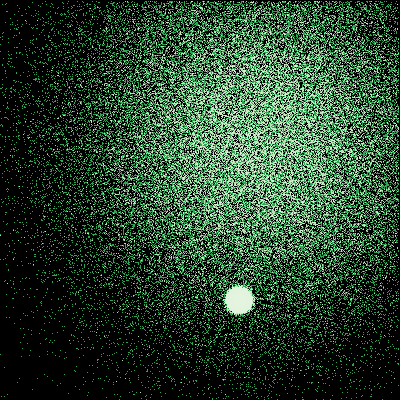

In [4]:
img

# Visualization of census data in the US
We are going to see data from 300 million people living in the US. For that we are going to use the [Racial dot map](http://www.coopercenter.org/demographics/Racial-Dot-Map) dataset created by the Cooper Center, which gathered data of the population density and ethnicity makeup of the USA. The first step is to download the data as an HDF5 file. 

Disclaimer: Even though the data and its creators distinguish each ethnicity as "race", there is no scientific evidence of it. The [notion of human races is a myth](http://www.americanscientist.org/bookshelf/pub/race-finished) as it has been proved by science, it is just another excuse to make us apart. In this [post](https://miguelgfierro.com/blog/2016/how-human-intelligence-works-and-why-that-makes-us-racists/) I argue that the origin of racism is based on how human intelligence is built and how stupid we are. Therefore, I will use the word ethnicity to refer persons from different communities. 

In [8]:
def download_data(infile):
    if(os.path.isfile(infile)):
        print("File %s already downloaded" % infile)
    else:
        url = 'http://s3.amazonaws.com/bokeh_data/census.zip'
        wget.download(url)
        output_path = os.path.basename(url)
        with zipfile.ZipFile(output_path, 'r') as zipf:
            zipf.extractall()
        os.remove(output_path)
census_data = 'census.h5'
download_data(census_data)

File census.h5 already downloaded


The next step is to import the data using pandas. The data consist on more than 300 million data points and each ethnicity has been encoded as a character (where 'w' is white, 'b' is black, 'a' is Asian, 'h' is Hispanic, and 'o' is other (typically Native American)).

The data in the dataset uses a format called [web mercator](https://en.wikipedia.org/wiki/Web_Mercator) which is a cilindrical projection of the world coordinates. It was invented in 1569 by [Gerardus Mercator](https://en.wikipedia.org/wiki/Mercator_projection) and became the standard format for nautical purposes. The web mercator format is an adaptation of the original mercator format and it is currently used by most modern map systems such as Google Maps, Bing Maps or OpenStreetMaps.

In [19]:
%%time
df = pd.read_hdf('census.h5', 'census')
df = df.rename(columns = {'race':'ethnic_group'})
df.ethnic_group = df.ethnic_group.astype('category')

Opening census.h5 in read-only mode
CPU times: user 20 s, sys: 11.1 s, total: 31.1 s
Wall time: 31.1 s


Now we are going to prepare the canvas and plot our first map. This map shows all the points in the dataset with the Hot color of datashader.

In [28]:
%%time
USA = ((-13884029,  -7453304), (2698291, 6455972))
plot_width  = int(900)
plot_height = int(plot_width*7.0/12)
cvs = ds.Canvas(plot_width, plot_height, *USA)
agg = cvs.points(df, 'meterswest', 'metersnorth')
cm = partial(colormap_select, reverse=(background!="black"))
img = tf.shade(agg, cmap = cm(Hot,0.2), how='eq_hist')
img = tf.set_background(img, background)

CPU times: user 6.88 s, sys: 0 ns, total: 6.88 s
Wall time: 6.88 s


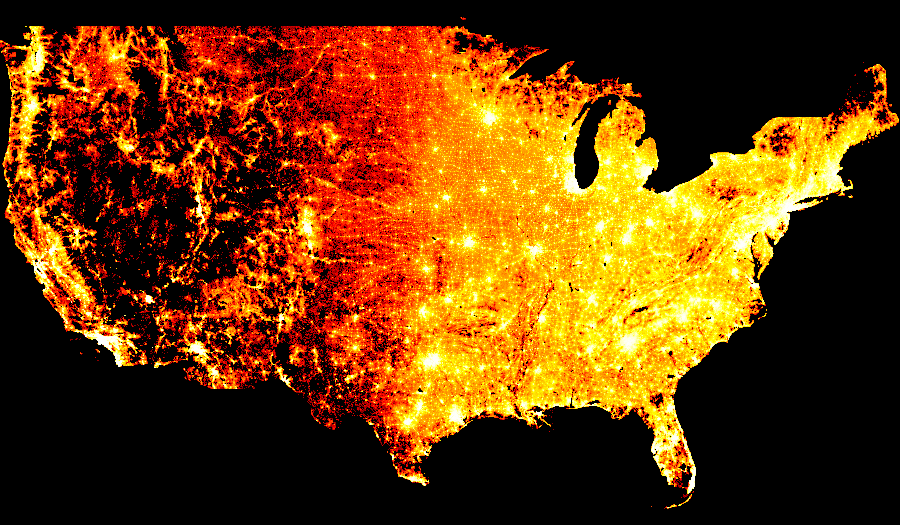

In [29]:
img

### Visualization of Champions League matches
We can easily create a visualization of the Champion League matches from 1955 to 2016 using datashader. For that we need a dataset of the matches, such as [this one](https://github.com/jalapic/engsoccerdata/blob/master/data-raw/champs.csv) and the coordinates of the Stadiums of the teams, that you can find [here](http://opisthokonta.net/?cat=34). 

The first step is to treat the data.

In [33]:
df_match = pd.read_csv("champions.csv")
df_stadium = pd.read_csv("stadiums.csv")
df_match.head()
df_stadium.head()
dd = df_stadium[['Latitude','Longitude']]
dd1 = dd.take([0,99, 64, 121])
dd1

,Latitude,Longitude
0,51.555000,-0.108611
99,40.453060,-3.688350
64,48.218775,11.624753
121,48.841389,2.253056


We have to transform the latitude and longitude coordinates to web mercator format in order to be able to represent it in a map using bokeh. 

In [63]:
def to_web_mercator(yLat, xLon):
    # Check if coordinate out of range for Latitude/Longitude
    if (abs(xLon) > 180) and (abs(yLat) > 90):
        
        return
 
    semimajorAxis = 6378137.0  # WGS84 spheriod semimajor axis
    east = xLon * 0.017453292519943295
    north = yLat * 0.017453292519943295
 
    northing = 3189068.5 * math.log((1.0 + math.sin(north)) / (1.0 - math.sin(north)))
    easting = semimajorAxis * east
 
    return [easting, northing]
dd2 = dd1.apply(lambda row: to_web_mercator(row['Latitude'], row['Longitude']), axis=1)
#dd2.iloc[2] = [np.NaN, np.NaN]
#ddnan = pd.DataFrame([np.NaN, np.NaN], columns = ['Latitude','Longitude'])
ddnan = pd.DataFrame([{'Latitude':np.NaN, 'Longitude':np.NaN}])
#dd3 = pd.concat([dd2[2:], ddnan, dd2[:2]], ignore_index=True)
dd3 = pd.concat([dd2[2:], ddnan, dd2[:2], ddnan, dd2[:2], ddnan, dd2[:2], ddnan, dd2[:2], ddnan, dd2[:2]], ignore_index=True)
dd3

,Latitude,Longitude
0,1.294062e+06,6.143329e+06
1,2.508090e+05,6.247991e+06
2,NaN,NaN
3,-1.209052e+04,6.720060e+06
4,-4.105852e+05,4.932000e+06
5,NaN,NaN
6,-1.209052e+04,6.720060e+06
7,-4.105852e+05,4.932000e+06
8,NaN,NaN
9,-1.209052e+04,6.720060e+06


In [65]:
plot_width  = 850
plot_height = 600
x_range = (-2.0e6, 2.5e6)
y_range = (4.1e6, 7.8e6)
def create_image(x_range=x_range, y_range=y_range, w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.line(dd3, 'Latitude', 'Longitude',  ds.count())
    img = tf.shade(agg)
        
    return img

def base_plot(tools='pan,wheel_zoom,reset',plot_width=plot_width, plot_height=plot_height,**plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    
    return p

#img = create_image(dd1)
ArcGIS=WMTSTileSource(url='http://server.arcgisonline.com/ArcGIS/rest/services/World_Street_Map/MapServer/tile/{Z}/{Y}/{X}.png')
p = base_plot()
p.add_tile(ArcGIS)
InteractiveImage(p, create_image)



Some of the code in this notebook has been taken from the example folder of [datashader](https://github.com/bokeh/datashader/tree/master/examples).